In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from Utils import SpEC_class_2 as spu
from scipy.integrate import cumulative_trapezoid 


In [3]:
path_to_data=Path.cwd().joinpath('Data')

# get every file in the data folder
files = path_to_data.glob('*.parquet')

files_filtered = [file for file in files if 'SW_SpEC' in file.name]

SW_dict = {}
for file in files_filtered:
    SW_dict[float(file.stem.split('_')[-1])] = pd.read_parquet(file)



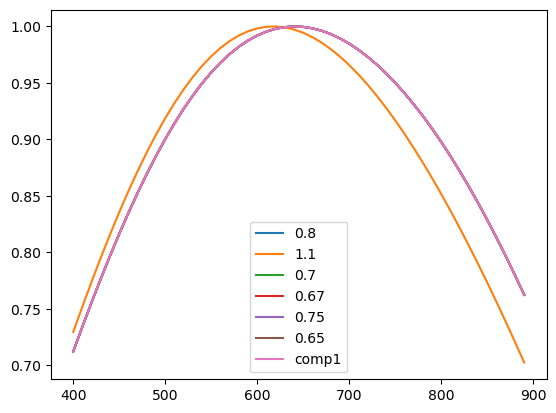

In [4]:
max_spec_dict={}
for key, SW in SW_dict.items():
    max_spec=spu.extract_average_spectrum_in_voltage_window(SW, voltage_window_lower=45, voltage_window_upper=50)
    max_spec_dict[key]=max_spec/np.max(max_spec)

for key, spec in max_spec_dict.items():
    plt.plot(spec, label=key)

comp1_spect=pd.read_csv(Path.cwd().joinpath('Data').joinpath('comp1spectrum.csv'))

plt.plot(comp1_spect.iloc[:,0], comp1_spect.iloc[:,1], label='comp1')


plt.legend()



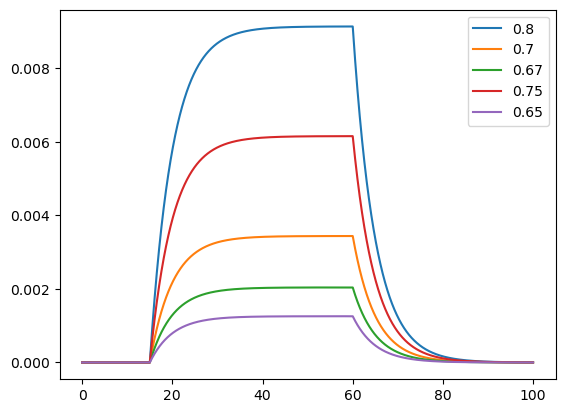

In [5]:
kin_dict_610nm={}
for key, SW in SW_dict.items():
    kin_dict_610nm[key]=SW.loc[610]


# drop the key 1.1
kin_dict_610nm.pop(1.1, None)

for key, kin in kin_dict_610nm.items():
    plt.plot(kin, label=key)


plt.legend()

A_max_dict={}   

for key, kin in kin_dict_610nm.items():
    A_max_dict[key]=np.max(kin)


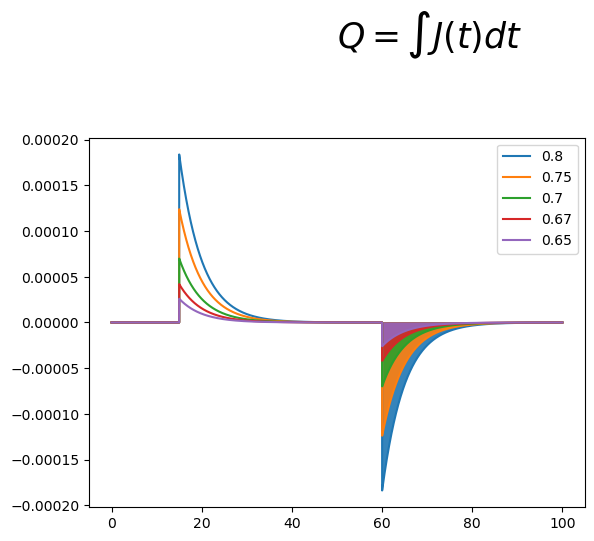

In [6]:
# read PD_J_dyn.parquet
PD_J_dyn = pd.read_parquet(Path.cwd().joinpath('Data').joinpath('J_SW_all.parquet'))

# drop the key 1.1
PD_J_dyn.drop(columns=[1.1], inplace=True)

# fill the area under each curve after 50s
PD_J_dyn_negative = PD_J_dyn.copy()


for col in PD_J_dyn_negative.columns:
    PD_J_dyn_negative[col] = list(map(lambda x, idx: x if idx > 60 else np.NaN, PD_J_dyn_negative[col], PD_J_dyn_negative.index))


# Plot the filled area
plt.figure()
for col in reversed(PD_J_dyn_negative.columns):

    plt.plot(PD_J_dyn.index, PD_J_dyn[col], label=np.round(float(col),3))

    plt.fill_between(PD_J_dyn_negative.index, PD_J_dyn_negative[col], alpha=0.9)

# place an integration symbol on the plot
plt.text(50, 0.0003, rf'$ Q= \int J(t) dt $', fontsize=25)

plt.legend()
plt.show()

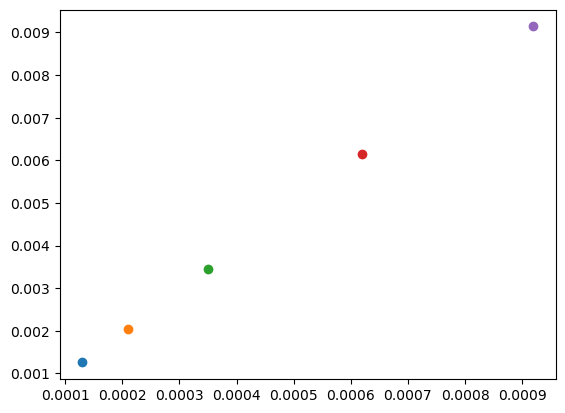

In [7]:
cumulative_trapezoid(PD_J_dyn_negative[0.65].dropna(), x=PD_J_dyn_negative[0.65].dropna().index)

Q_max_dict={}
for key, value in PD_J_dyn_negative.items():
    Q_max_dict[float(key)]=abs(cumulative_trapezoid(value.dropna(), x=value.dropna().index).min())

plotlist:list[tuple]=[]
for keyQ, Q in Q_max_dict.items():
    A=A_max_dict[keyQ]
    plotlist.append((Q, A))
    plt.scatter(Q, A, label=keyQ)



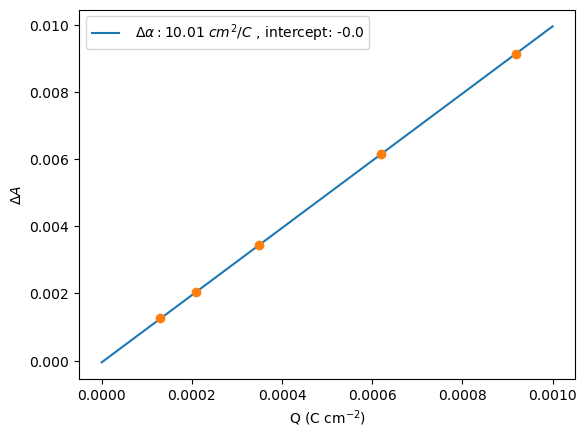

In [8]:
# linear regression of plotlist
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress([x for x, y in plotlist], [y for x, y in plotlist])

x = np.linspace(0, 0.001, 100)
y = slope*x + intercept
plt.plot(x, y, label=fr' $\Delta \alpha: ${np.round(float(slope),2)} $cm^2/C$ , intercept: {np.round(float(intercept),2)}')

# co plot with data from plotlist
plt.plot([x for x, y in plotlist], [y for x, y in plotlist], 'o')

# label the x axis Q (C cm^-2)
plt.xlabel(r'Q (C cm$^{-2}$)')
# label the y axis $\Delta A$
plt.ylabel(r'$\Delta A$')

plt.legend()

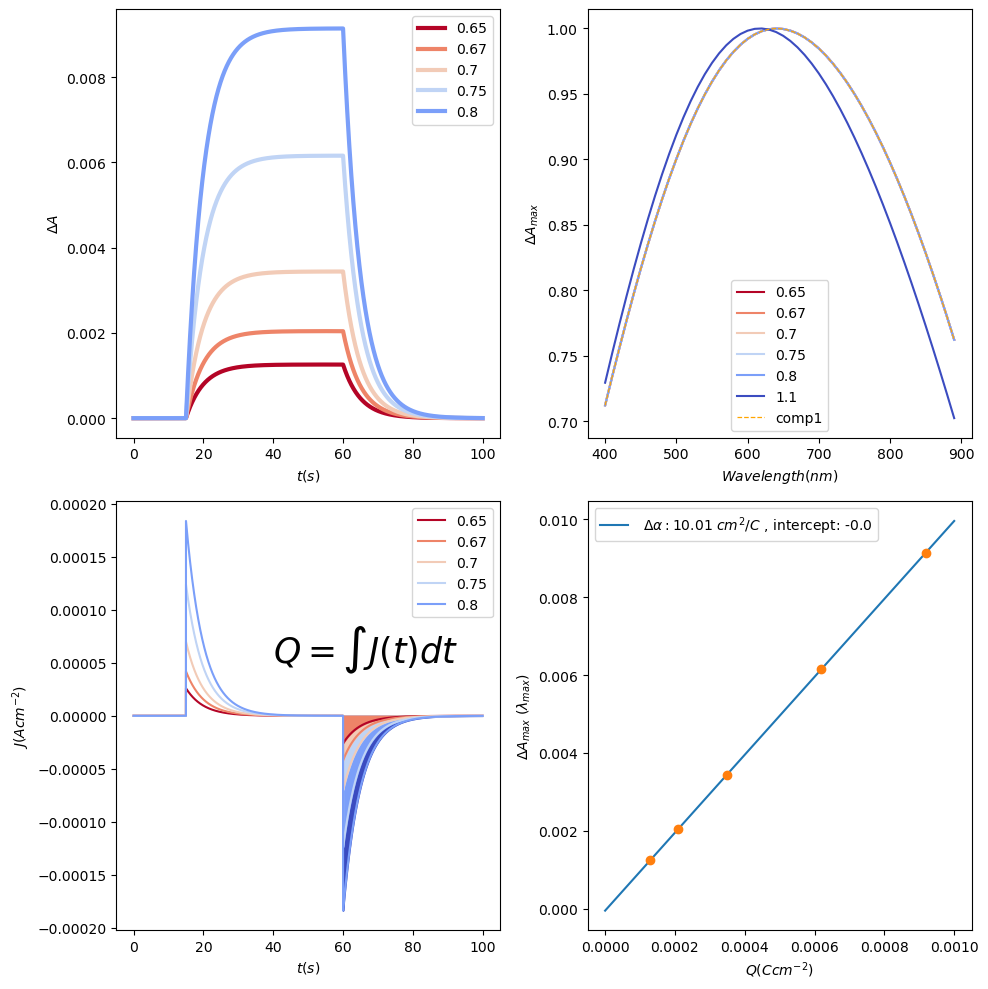

In [15]:
# now combine everything into a single 2x2 panel

import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# Sort the dictionaries by key
sorted_max_spec_dict = OrderedDict(sorted(max_spec_dict.items()))
sorted_kin_dict_610nm = OrderedDict(sorted(kin_dict_610nm.items()))

# create a cool warm colormap for each key in sorted_kin_dict_610nm
colors = plt.cm.coolwarm(np.linspace(1, 0, len(sorted_kin_dict_610nm)+1))

# Create a 2x2 panel with the specified figure size
fig, ax = plt.subplots(2, 2, figsize=(10, 10))







# Plot sorted_kin_dict_610nm on the second subplot (bottom-left)
for i, (key, kin) in enumerate(sorted_kin_dict_610nm.items()):
    kin.plot(ax=ax[0, 0], label=key, color=colors[i], linewidth=3)
# legend for ax[0, 0] in a custimized location
ax[0, 0].legend(loc='upper right')





# Use fill_between on the third subplot (top-right)
for i, col in enumerate(PD_J_dyn_negative.columns):

        ax[1, 0].plot(PD_J_dyn.index, PD_J_dyn[col], label=np.round(float(col), 3), color=colors[i])

for i, col in (enumerate(reversed(PD_J_dyn_negative.columns))):
    ax[1, 0].fill_between(PD_J_dyn_negative.index, PD_J_dyn_negative[col], alpha=1, color=colors[5-i])

# place an integration symbol on the plot
ax[1, 0].text(40, 0.00005, rf'$ Q= \int J(t) dt $', fontsize=25)

ax[1, 0].legend()




# Plot comp1_spect on the first subplot (top-left)
for i, (key, spec) in enumerate(sorted_max_spec_dict.items()):
    ax[0, 1].plot(spec, label=key, color=colors[i])
ax[0, 1].plot(comp1_spect.iloc[:, 0], comp1_spect.iloc[:, 1], label='comp1', linewidth=0.9, linestyle='--', color='orange')
ax[0, 1].legend()




ax[1,1].plot(x, y, label=fr' $\Delta \alpha: ${np.round(float(slope),2)} $cm^2/C$ , intercept: {np.round(float(intercept),2)}')

# co plot with data from plotlist
ax[1,1].plot([x for x, y in plotlist], [y for x, y in plotlist], 'o')

# label the x axis Q (C cm^-2)
ax[1,1].set_xlabel(r'Q (C cm$^{-2}$)')
# label the y axis $\Delta A$
ax[1,1].set_ylabel(r'$\Delta A_{max}$')

ax[1,1].legend()

# set the y axis label for the first subplot to be $\Delta A$
ax[0, 0].set_ylabel(r'$\Delta A$')
# set the y axis label for the second subplot to be $\Delta A_{max}$
ax[0, 1].set_ylabel(r'$\Delta A_{max}$')
# set the y axis label for the third subplot to be $J (A cm^{-2})$
ax[1, 0].set_ylabel(r'$J (A cm^{-2})$')
# set the y axis label for the fourth subplot to be $\Delta A_{max}$
ax[1, 1].set_ylabel(r'$\Delta A_{max} \ (\lambda_{max} )$')

# set the x axis label for the first subplot to be $t (s)$
ax[0, 0].set_xlabel(r'$t (s)$')
# set the x axis label for the second subplot to be $Wavelength (nm)$
ax[0, 1].set_xlabel(r'$Wavelength (nm)$')
# set the x axis label for the third subplot to be $t (s)$
ax[1, 0].set_xlabel(r'$t (s)$')
# set the x axis label for the fourth subplot to be $Q (C cm^{-2})$
ax[1, 1].set_xlabel(r'$Q (C cm^{-2})$')
plt.tight_layout()
plt.show()